In [181]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.io import loadmat

def check_tf_gpu():
    sys_info = tf.sysconfig.get_build_info()
    version, cuda, cudnn = tf.__version__, sys_info["cuda_version"], sys_info["cudnn_version"]
    count = len(tf.config.experimental.list_physical_devices())
    name  = [device.name for device in tf.config.experimental.list_physical_devices('GPU')]
    print('-'*66)
    print('-'*26, 'VERSION INFO', '-'*26)
    print('TF version: {} | # Device(s) available: {}'.format(version, count))
    print('TF Built with CUDA? {} | CUDA: {} | cuDNN: {}'.format(tf.test.is_built_with_cuda(), cuda, cudnn))
    print(tf.config.list_physical_devices()[0],'\n', tf.config.list_physical_devices()[1])
    print('-'*66+'\n')
    return None

check_tf_gpu()

import einops
from tensorflow import einsum

import tensorflow as tf
from tensorflow.image import ssim as tf_ssim, psnr as tf_psnr

import keras
import keras.backend as K
from keras import Model
from keras import layers
from keras.layers import *
from keras.optimizers import AdamW
from keras.losses import MeanSquaredError, MeanAbsolutePercentageError

------------------------------------------------------------------
-------------------------- VERSION INFO --------------------------
TF version: 2.15.0 | # Device(s) available: 2
TF Built with CUDA? True | CUDA: 12.0 | cuDNN: 8
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU') 
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
------------------------------------------------------------------



In [305]:
sec2year   = 365.25 * 24 * 60 * 60
psi2pascal = 6894.76
co2_rho    = 686.5266
mega       = 1e6

n_timesteps = 33
nx, ny, nz, nz_short  = 100, 100, 11, 5

indexMap = loadmat('data_100_100_11/G_cells_indexMap.mat', simplify_cells=True)['gci']
Grid = np.zeros((nx,ny,nz)).flatten(order='F')
Grid[indexMap] = 1
Grid = Grid.reshape(nx,ny,nz, order='F')
Tops = np.load('data_npy_100_100_11/tops_grid.npz')['tops']
print('Grid: {} | Tops: {}'.format(Grid.shape, Tops.shape))

Grid: (100, 100, 11) | Tops: (100, 100, 11)


In [42]:
xx = np.load('data_npy_100_100_11/inputs_rock_Rates_locs_time/x_0.npz')
print(xx.keys())

KeysView(NpzFile 'data_npy_100_100_11/inputs_rock_Rates_locs_time/x_0.npz' with keys: poro, perm, locs, wlist, ctrl...)


In [161]:
class Conv2Plus1D(keras.layers.Layer):
  def __init__(self, filters, kernel_size, padding):
    """
      A sequence of convolutional layers that first apply the convolution operation over the
      spatial dimensions, and then the temporal dimension. 
    """
    super().__init__()
    self.seq = keras.Sequential([  
        # Spatial decomposition
        layers.Conv3D(filters=filters,
                      kernel_size=(1, kernel_size[1], kernel_size[2]),
                      padding=padding),
        # Temporal decomposition
        layers.Conv3D(filters=filters, 
                      kernel_size=(kernel_size[0], 1, 1),
                      padding=padding)
        ])

  def call(self, x):
    return self.seq(x)

In [423]:
def make_model():
    K.clear_session()
    inp_xm = Input(shape=(29128, 2))
    inp_xg = Input(shape=(29128, 2))
    inp_xw = Input(shape=(2, 5))
    inp_xc = Input(shape=(None, 5))
    inp_xt = Input(shape=(None, 1))
    inputs = [inp_xm, inp_xg, inp_xw, inp_xc, inp_xt]

    def conv_block(inp, filt):
        _ = Masking(mask_value=0.)(inp)
        _ = Conv2Plus1D(filters=filt, kernel_size=(3,3,3), padding='same')(_)
        _ = GroupNormalization(groups=-1)(_)
        _ = Activation('gelu')(_)
        _ = Conv2Plus1D(filters=filt, kernel_size=(3,3,3), padding='same')(_)
        _ = GroupNormalization(groups=-1)(_)
        _ = Activation('gelu')(_)
        _ = MaxPooling3D((2,2,1))(_)
        return _
    
    def triple_dense_block(inp, units):
        def dense_block(inp, units):
            _ = Dense(units)(inp)
            _ = GroupNormalization(groups=-1)(_)
            _ = Activation('gelu')(_)
            return _
        _ = dense_block(inp, units)
        _ = dense_block(_, units)
        _ = dense_block(_, units)
        return _
    
    def recc_block(inp, units):
        _ = LSTM(units, return_sequences=True)(inp)
        _ = LayerNormalization()(_)
        _ = Activation('gelu')(_)
        _ = LSTM(units, return_sequences=True)(_)
        _ = LayerNormalization()(_)
        _ = Activation('gelu')(_)
        return _
    
    def decon_block(inp, filt):
        _ = TimeDistributed(Conv2Plus1D(filters=filt, kernel_size=(3,3,3), padding='same'))(inp)
        _ = GroupNormalization(groups=-1)(_)
        _ = Activation('gelu')(_)
        _ = TimeDistributed(Conv2Plus1D(filters=filt, kernel_size=(3,3,3), padding='same'))(_)
        _ = GroupNormalization(groups=-1)(_)
        _ = Activation('gelu')(_)
        _ = TimeDistributed(Conv3DTranspose(filt//4, 3, strides=(2,2,1), padding='same'))(_)
        return _
    
    # xm = conv_block(inp_xm, 64)
    # xm = conv_block(xm, 128)

    # xg = conv_block(inp_xg, 64)
    # xg = conv_block(xg, 128)

    xm = triple_dense_block(inp_xm, 100)
    xg = triple_dense_block(inp_xg, 100)

    xw = recc_block(inp_xw, 50)
    xw = triple_dense_block(xw, 100)

    xc = recc_block(inp_xc, 50)
    xc = triple_dense_block(xc, 100)

    xt = recc_block(inp_xt, 50)
    xt = triple_dense_block(xt, 100)

    mg = einsum('bpc, bpc -> bpc', xm, xg)
    wc = einsum('blc, btc -> btlc', xw, xc)

    branch = einsum('bpc, btlc -> btpc', mg, wc)
    trunk  = einsum('btpc, btc -> btpc', branch, xt)

    x = Dense(2)(trunk)
    

    # x = decon_block(trunk, 128)
    # x = decon_block(x, 64)
    # x = TimeDistributed(Conv2Plus1D(filters=2, kernel_size=(3,3,3), padding='same'))(x)

    return Model(inputs=inputs, outputs=x)

In [424]:
model = make_model()
print('# Parameters: {:,}'.format(model.count_params()))

# Parameters: 214,102


In [425]:
train_idx = np.random.choice(range(1272), size=8, replace=False)
test_idx  = np.setdiff1d(range(1272), train_idx)

In [426]:
# xm = np.zeros((len(train_idx), nx, ny, nz_short, 2))
# xg = np.zeros((len(train_idx), nx, ny, nz_short, 2))
xm = np.zeros((len(train_idx), 29128, 2))
xg = np.zeros((len(train_idx), 29128, 2))
xw = np.zeros((len(train_idx), 2, 5))
xc = np.zeros((len(train_idx), n_timesteps, 5))
xt = np.zeros((len(train_idx), n_timesteps, 1))

def apply_mask(x, imap, mask_value=0.0):
    xx = mask_value*np.ones((nx,ny,nz)).flatten(order='F')
    xx[imap] = x.flatten(order='F')[imap]
    xx = xx.reshape((nx,ny,nz), order='F')[...,5:10]
    return xx

for i in range(len(train_idx)):
    # xg[i] = np.expand_dims(np.concatenate([np.expand_dims(Grid[...,5:10], -1), np.expand_dims(Tops[...,5:10], -1)], -1), 0)
    g = np.expand_dims(Grid.flatten(order='F')[indexMap], -1)
    t = np.expand_dims(Tops.flatten(order='F')[indexMap], -1)
    xg[i] = np.expand_dims(np.concatenate([g, t], -1), 0)

    m = np.load('data_npy_100_100_11/inputs_rock_Rates_locs_time/x_{}.npz'.format(train_idx[i]))
    # p = np.expand_dims(apply_mask(m['poro'], indexMap), -1)
    # k = np.expand_dims(apply_mask(m['perm'], indexMap, mask_value=-9), -1)
    p = np.expand_dims(m['poro'].flatten(order='F')[indexMap], -1)
    k = np.expand_dims(m['perm'].flatten(order='F')[indexMap], -1)
    xm[i] = np.concatenate([p, k], -1)

    xw[i] = m['locs']
    xc[i] = m['ctrl']
    xt[i] = m['time']

print('xm', xm.shape)
print('xg', xg.shape)
print('xw', xw.shape)
print('xc', xc.shape)
print('xt', xt.shape)

xm (8, 29128, 2)
xg (8, 29128, 2)
xw (8, 2, 5)
xc (8, 33, 5)
xt (8, 33, 1)


In [427]:
model([xm, xg, xw, xc, xt]).shape

2024-07-10 00:33:17.520330: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.86GiB (rounded to 3075916800)requested by op Einsum
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-07-10 00:33:17.520418: I external/local_tsl/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2024-07-10 00:33:17.520432: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 767, Chunks in use: 767. 191.8KiB allocated for chunks. 191.8KiB in use in bin. 152.6KiB client-requested in use in bin.
2024-07-10 00:33:17.520436: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 1207, Chunks in use: 1207. 624.5KiB allocated for chunks. 624.5KiB in use in bin. 598.7KiB client-requested in use in bin.
2024-07-10

ResourceExhaustedError: Exception encountered when calling layer 'tf.einsum_2' (type TFOpLambda).

{{function_node __wrapped__Einsum_N_2_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[8,33,29128,100] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Einsum] name: 

Call arguments received by layer 'tf.einsum_2' (type TFOpLambda):
  • equation='bpc, btlc -> btpc'
  • inputs=('tf.Tensor(shape=(8, 29128, 100), dtype=float32)', 'tf.Tensor(shape=(8, 33, 2, 100), dtype=float32)')
  • kwargs=<class 'inspect._empty'>

ernal/local_tsl/tsl/framework/bfc_allocator.cc:1103] 1 Chunks of size 244224 totalling 238.5KiB
2024-07-10 00:33:17.526542: I external/local_tsl/tsl/framework/bfc_allocator.cc:1103] 5 Chunks of size 245760 totalling 1.17MiB
2024-07-10 00:33:17.526544: I external/local_tsl/tsl/framework/bfc_allocator.cc:1103] 3 Chunks of size 262144 totalling 768.0KiB
2024-07-10 00:33:17.526547: I external/local_tsl/tsl/framework/bfc_allocator.cc:1103] 1 Chunks of size 270336 totalling 264.0KiB
2024-07-10 00:33:17.526549: I external/local_tsl/tsl/framework/bfc_allocator.cc:1103] 1 Chunks of size 286720 totalling 280.0KiB
2024-07-10 00:33:17.526551: I external/local_tsl/tsl/framework/bfc_allocator.cc:1103] 48 Chunks of size 294912 totalling 13.50MiB
2024-07-10 00:33:17.526553: I external/local_tsl/tsl/framework/bfc_allocator.cc:1103] 1 Chunks of size 296960 totalling 290.0KiB
2024-07-10 00:33:17.526555: I external/local_tsl/tsl/framework/bfc_allocator.cc:1103] 2 Chunks of size 311296 totalling 608.0KiB
2

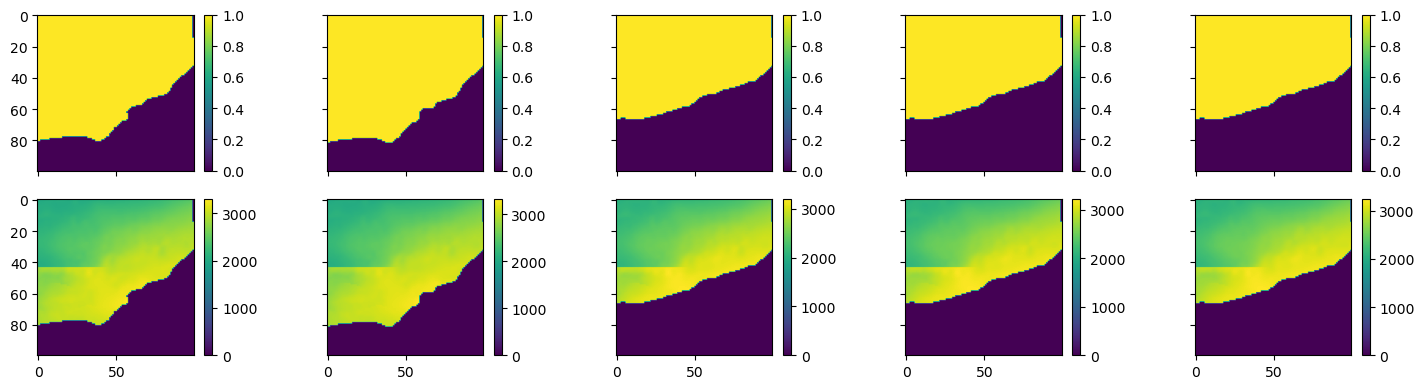

In [319]:
fig, axs = plt.subplots(2, 5, figsize=(15,4), sharex=True, sharey=True)
for i in range(2):
    for j in range(5):
        ax = axs[i,j]
        im = ax.imshow(xg[2,...,j,i])
        plt.colorbar(im, pad=0.04, fraction=0.046)
plt.tight_layout()
plt.show()

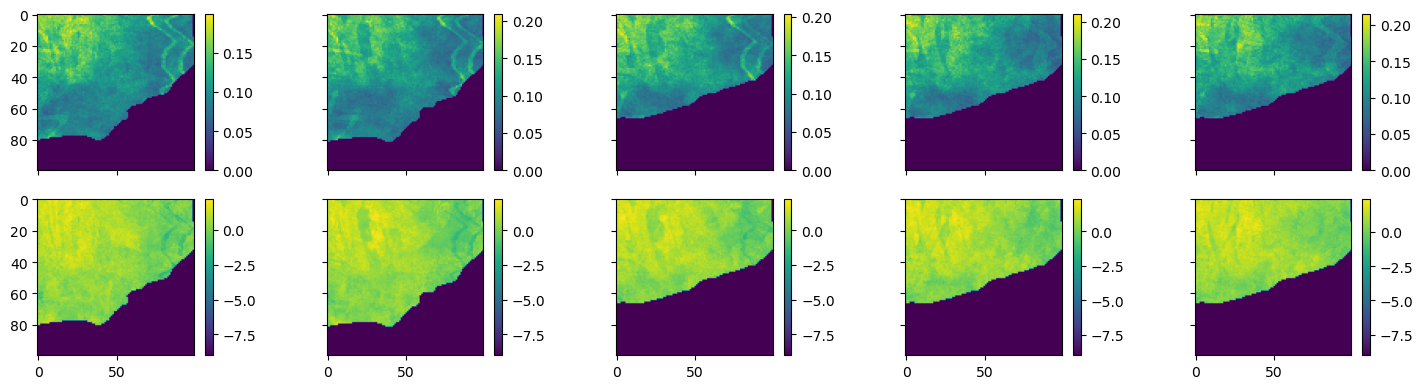

In [320]:
fig, axs = plt.subplots(2, 5, figsize=(15,4), sharex=True, sharey=True)
for i in range(2):
    for j in range(5):
        ax = axs[i,j]
        im = ax.imshow(xm[2,...,j,i])
        plt.colorbar(im, pad=0.04, fraction=0.046)
plt.tight_layout()
plt.show()

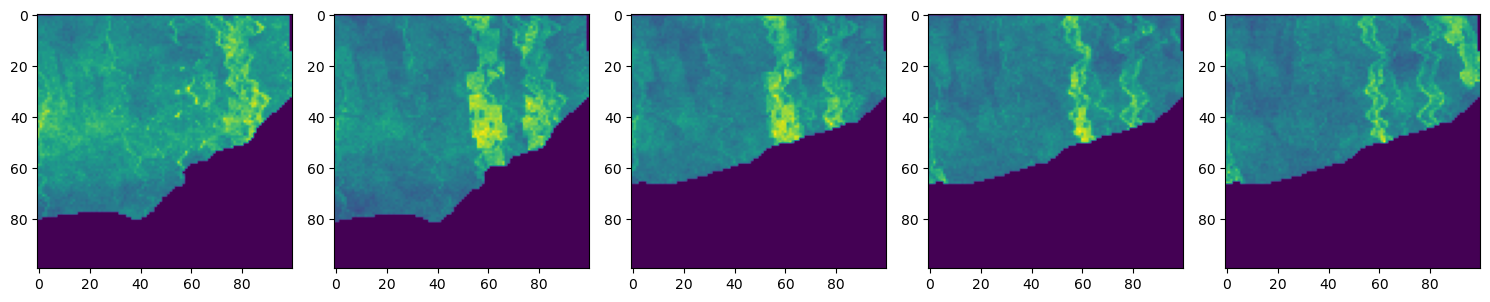

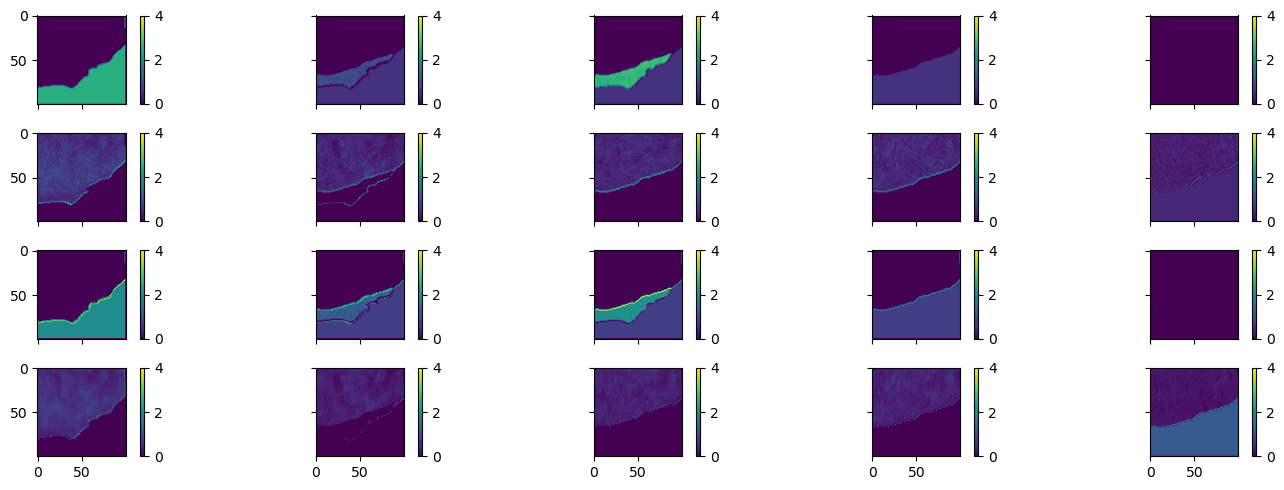

In [349]:
plt.figure(figsize=(15,4))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(xm[0,...,i,0])
plt.tight_layout()
plt.show()

t = Conv2Plus1D(4, (3,3,3), padding='same')(xm)
t = GroupNormalization(groups=-1)(t)
t = Activation('gelu')(t)
fig, axs = plt.subplots(4, 5, figsize=(15,5), sharex=True, sharey=True)
for i in range(4):
    for j in range(5):
        ax = axs[i,j]
        im = ax.imshow(t[0,...,j,i], vmin=0, vmax=4)
        plt.colorbar(im, pad=0.04, fraction=0.046)
plt.tight_layout()
plt.show()

***
# END